In [4]:
import pandas as pd
import numpy as np

import os
import math

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.vgg16 import VGG16
from keras.applications import DenseNet121
from keras.optimizers import Adam

from keras.callbacks import Callback
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2
import tensorflow as tf

from sklearn.metrics import cohen_kappa_score, accuracy_score

from tqdm import tqdm, tqdm_notebook
from livelossplot import PlotLossesKeras

from efficientnet.keras import EfficientNetB5

%matplotlib inline

seed = 2020
imgSize = 200
numChannels = 3
numClasses = 5
train_dir = "train"
test_dir = "test"

In [5]:
# read
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

def read_data(df, df_dir):
    features = []
    target = []
    images = df['id_code'].values
    for img_id in tqdm_notebook(images):
        image_file = df_dir + "/" + img_id + '.png'
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (imgSize, imgSize))
        blur = cv2.GaussianBlur(image, (0,0), imgSize/10)
        image = cv2.addWeighted(image, 4, blur, -4, 128)
        features.append(image)    
        
    features = np.asarray(features)
    return features

X_train, y_train = read_data(train_df, train_dir), np.asarray(train_df.diagnosis)
y_trainc = np_utils.to_categorical(y_train)

input_shape = (imgSize, imgSize, numChannels)

In [6]:
X_train_s, y_train_s = shuffle(X_train, y_trainc, random_state=seed)
train_x, valid_x, train_y, valid_y = train_test_split(X_train_s, y_train_s, test_size=0.15,
                                                      stratify=y_train_s, random_state=seed)

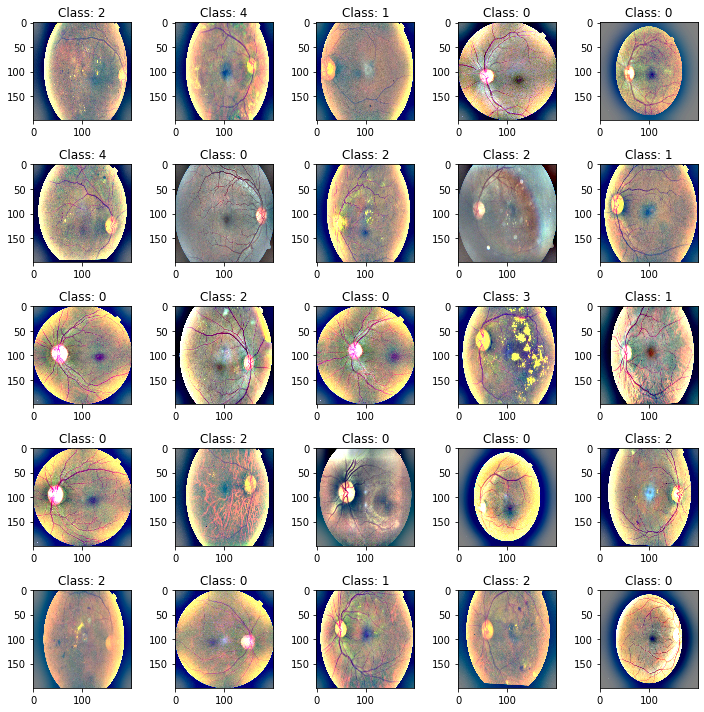

In [6]:
def plot_eyes(x, y, top=25):
  #dfd = df.loc[df.diagnosis == diagnosis].sample(top)
  dfd = x
  plt.figure(figsize=(10, 10))
  for idx in range(top):
    pics_per_row = int(top**.5)
    plt.subplot(pics_per_row, pics_per_row, idx + 1)
    
    plt.imshow(dfd[idx])
    plt.title('Class: {}'.format(y_train[idx]))

  plt.tight_layout()

plot_eyes(X_train, y_train)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(train_x.shape)
print(valid_x.shape)
print(train_y.shape)
print(valid_y.shape)

(3662, 200, 200, 3)
(3662,)
(3112, 200, 200, 3)
(550, 200, 200, 3)
(3112, 5)
(550, 5)


In [7]:
# Kappa metric and callback
# import keras.backend as K
# def _cohen_kappa(y_true, y_pred, num_classes, weights=None, metrics_collections=None, updates_collections=None, name=None):
#    kappa, update_op = tf.contrib.metrics.cohen_kappa(y_true, y_pred, num_classes, weights, metrics_collections, updates_collections, name)
#    K.get_session().run(tf.local_variables_initializer())
#    with tf.control_dependencies([update_op]):
#       kappa = tf.identity(kappa)
#    return kappa

# def cohen_kappa_loss(num_classes, weights=None, metrics_collections=None, updates_collections=None, name=None):
#    def cohen_kappa(y_true, y_pred):
#       return -_cohen_kappa(y_true, y_pred, num_classes, weights, metrics_collections, updates_collections, name)
#    return cohen_kappa

# model_cohen_kappa = cohen_kappa_loss(num_classes=1, weights='quadratic')
# def get_cohen_kappa(weights=None):
#     def cohen_kappa_score_(y_true, y_pred):        
#         _val_kappa = cohen_kappa_score(y_true, y_pred, weights)
#         return _val_kappa
#     return cohen_kappa_score_


class KappaMetrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        print("Validation data len=" + str(len(self.validation_data)))
        
        X_val, y_val = self.validation_data[:2]
        #y_val = y_val.sum(axis=1) - 1
        y_val = y_val.argmax(1)
        
        y_pred = self.model.predict(X_val) > 0.5
        #y_pred = y_pred.astype(int).sum(axis=1) - 1
        y_pred = y_pred.argmax(1)

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

In [8]:
# EfficientNet
effnet = EfficientNetB5(include_top=False, 
                   weights='imagenet', 
                   input_shape=input_shape)

model = Sequential([
    effnet,    
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(numClasses, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.00005),
    metrics=['accuracy']
)

W0908 14:24:37.178972 139799519029056 deprecation_wrapper.py:119] From /home/lkoziol/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0908 14:24:37.188776 139799519029056 deprecation_wrapper.py:119] From /home/lkoziol/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0908 14:24:37.190849 139799519029056 deprecation_wrapper.py:119] From /home/lkoziol/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0908 14:24:37.204227 139799519029056 deprecation_wrapper.py:119] From /home/lkoziol/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1

In [ ]:
# DenseNet
densenet = DenseNet121(
    include_top=False,
    weights='DenseNet-BC-121-32-no-top.h5',
    input_shape=input_shape
)

model = Sequential([
    densenet,    
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(numClasses, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.00005),
    metrics=['accuracy']
)

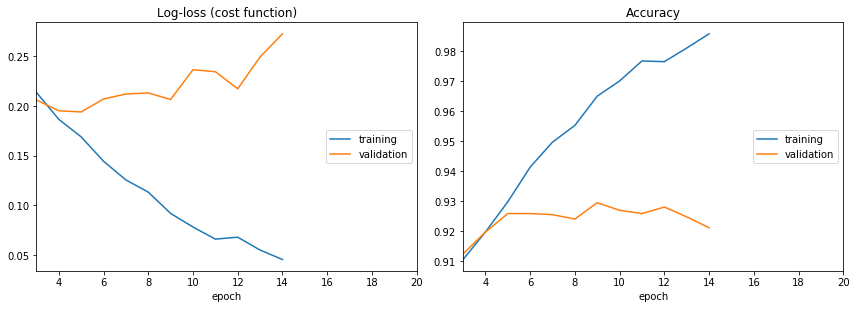

Log-loss (cost function):
training   (min:    0.045, max:    0.438, cur:    0.045)
validation (min:    0.194, max:    0.273, cur:    0.273)

Accuracy:
training   (min:    0.807, max:    0.986, cur:    0.986)
validation (min:    0.892, max:    0.929, cur:    0.921)
Validation data len=4
val_kappa: 0.8196
Epoch 15/20
1045/3112 [=========>....................] - ETA: 14:21 - loss: 0.0393 - acc: 0.9860

KeyboardInterrupt: 

In [9]:
# Efficient Net 5, batch=19
model.fit(train_x, train_y, 
          validation_data=(valid_x, valid_y),
          batch_size=19, epochs=20,
          callbacks=[PlotLossesKeras(),
                     KappaMetrics()])   

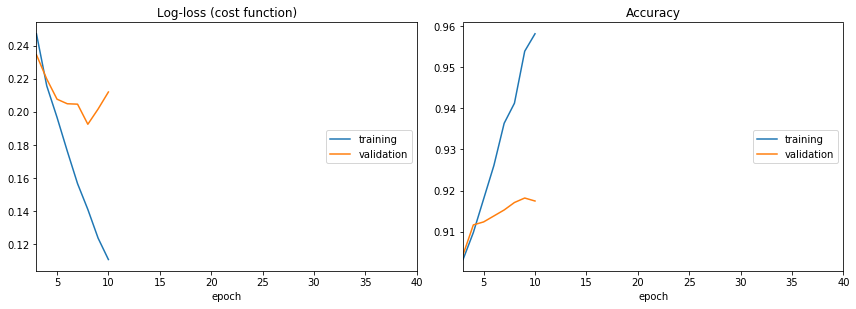

Log-loss (cost function):
training   (min:    0.111, max:    0.539, cur:    0.111)
validation (min:    0.192, max:    0.363, cur:    0.212)

Accuracy:
training   (min:    0.740, max:    0.958, cur:    0.958)
validation (min:    0.889, max:    0.918, cur:    0.917)
Validation data len=4
val_kappa: 0.6900
Validation Kappa has improved. Saving model.
Epoch 11/40
3080/3112 [============================>.] - ETA: 5s - loss: 0.1017 - acc: 0.9604 

KeyboardInterrupt: 

In [12]:
model.fit(train_x, train_y, 
          validation_data=(valid_x, valid_y),
          batch_size=77, epochs=40,
          callbacks=[PlotLossesKeras(),
                     KappaMetrics()])   

In [11]:
#3112/40
#77 40e - 8m per epoch 92% val acc

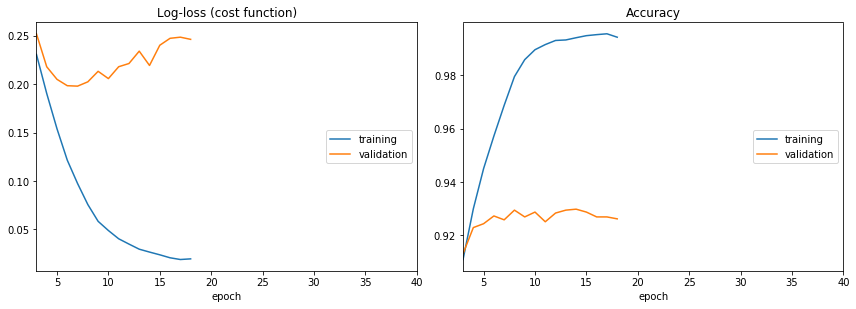

Log-loss (cost function):
training   (min:    0.019, max:    0.599, cur:    0.019)
validation (min:    0.198, max:    0.545, cur:    0.246)

Accuracy:
training   (min:    0.703, max:    0.996, cur:    0.994)
validation (min:    0.741, max:    0.930, cur:    0.926)
Validation data len=4
val_kappa: 0.7428
Epoch 19/40
 847/3112 [=======>......................] - ETA: 5:51 - loss: 0.0135 - acc: 0.9974

KeyboardInterrupt: 

In [7]:
# Train on 3112 samples, validate on 550 samples

model.fit(train_x, train_y, 
          validation_data=(valid_x, valid_y),
          batch_size=77, epochs=40,
          callbacks=[PlotLossesKeras(),
                     KappaMetrics()])    

Log-loss (cost function):
training   (min:    0.154, max:    0.599, cur:    0.154)
validation (min:    0.205, max:    0.545, cur:    0.205)

Accuracy:
training   (min:    0.703, max:    0.945, cur:    0.945)
validation (min:    0.741, max:    0.924, cur:    0.924)
Validation data len=4
val_kappa: 0.5778
Epoch 6/40

Log-loss (cost function):
training   (min:    0.019, max:    0.599, cur:    0.019)
validation (min:    0.198, max:    0.545, cur:    0.246)

Accuracy:
training   (min:    0.703, max:    0.996, cur:    0.994)
validation (min:    0.741, max:    0.930, cur:    0.926)
Validation data len=4
val_kappa: 0.7428
Epoch 19/40

#pred_y = model.predict(train_x)

In [33]:
pred_categorical = pred_y > .5
pred_int = pred_categorical.argmax(1)
train_y_int = train_y.argmax(1)

_val_kappa = cohen_kappa_score(
 train_y_int,
 pred_int, 
 weights='quadratic'
)
_val_kappa

0.9291846037916036

array([4, 0, 0, 3, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0])